<h1>VAST Challenge 2017</h1>

<h2><i>Mini Challenge 1</i></h2>

<br />

<h3>1. <u>Introduction</u></h3>

<p>At this present work we present our solution for the first challenge proposed at the 2017 VAST Challenge, where contestants, using visual analytics tools, are expected to find patterns in the data of the vehicle traffic of the ficticious Boonsong Lekagul Nature Preserve and relate them with the decline in the Rose-crested Blue Pipit bird species population at the park.</p>

<p>The mini-challenge encourages the participants to use visual analytics to identify repeating patterns of vehicles transiting the park and classify the most supicious ones among then, regarding to threatening the native species. To facilitate this task, the park provides us with traffic data containing an identification for each vehicle, the vehicle type and timestamps collected by the many sensors spreaded in the parks installations. Besides that, a simplified map of the park with the sensors locations is also provided.</p>

<p>Our approach to the problem was to first make an exploratory data analysis of the dataset to raise starting points for the problem investigation and then, afterwards, dive into these hypothesis, testing them with visual analytics tools.</p>

<p>To deal with the data and the plottings, our team choose to use Python 3 and some really useful packages that would make our work easier. In this document, created using <a href="http://jupyter.org/">Jupyter Notebook</a>, we provide both the source code and the execution output in hope that the understanding of the methodology used is clearer to our reader. All the visualizations created are also displayed inline.</p>

In [1]:
%matplotlib inline

<p>In this article we will be presenting our step-by-step investigations, including the raised hipothesis, the visualization choices to explore it, the code and the analysis, all along this beautiful notebook. We hope you're going to enjoy it.</p>


<p>All the project code is released under MIT License and is free for use and redistribution. Attribution is apreciated but not required. More information can be found at the project <a href="http://github.com/dmrib/daytripper">repository</a>.</p>

<h3>2. <u>Tools</u></h3>

<p>The project code was written using Python 3, due to the great productivity obteained in the handling with the data and because of the possibility of using the same language for data munging and to create visualizations. Some non-native packages were also used:</p>

<ul>
    <li>numpy</li>
<ul>

<p>NumPy is the fundamental package for scientific computing with Python. It contains among other things a powerful N-dimensional array object,
sophisticated (broadcasting) functions, tools for integrating C/C++ and Fortran code, useful linear algebra, Fourier transform, and random number capabilities.</p>

In [2]:
import numpy as np

<ul>
    <li>pandas</li>
<ul>

<p><i>pandas</i> is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.</p>

In [3]:
import pandas as pd

<ul>
    <li>matplotlib</li>
</ul>

<p>Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shell, the jupyter notebook, web application servers, and graphical user interface toolkits.</p>

In [4]:
import matplotlib.pyplot as plt

<ul>
    <li>seaborn</li>
</ul>

<p>Seaborn is a Python visualization library based on matplotlib. It provides a high-level interface for drawing attractive statistical graphics.</p>

In [5]:
import seaborn as sns

sns.set_style('whitegrid')

<ul>
    <li>graphviz</li>
</ul>

<p>Graphviz is open source graph visualization software. Graph visualization is a way of representing structural information as diagrams of abstract graphs and networks. It has important applications in networking, bioinformatics,  software engineering, database and web design, machine learning, and in visual interfaces for other technical domains. </p>

In [6]:
import graphviz

<h3>3. <u>Loading Data</u></h3>

<p>We start our work by loading the data using the <i>pandas</i> module.</p>

<p>The timestamps are converted to Python timestamps format to make the time operations easier afterwards.</p>

In [7]:
raw_dataset = pd.read_csv('../data/Lekagul Sensor Data.csv', parse_dates=["Timestamp"],
                      date_parser=lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

<h3>4. <u>Time Distributions Analysis</u></h3>



<p>A time distribution of our data entries could be useful for revealing inconsistent datums and to give a general spectre of the volume of traffic over the data collection time.</p> 

We start by extracting the year, month and day of each sensor entry:

In [8]:
time_data = raw_dataset

time_data['year'] = pd.DatetimeIndex(raw_dataset['Timestamp']).year
time_data['month'] = pd.DatetimeIndex(raw_dataset['Timestamp']).month
time_data['hour'] = pd.DatetimeIndex(raw_dataset['Timestamp']).hour

time_data.head()

,Timestamp,car-id,car-type,gate-name,year,month,hour
0,2015-05-01 00:43:28,20154301124328-262,4,entrance3,2015,5,0
1,2015-05-01 01:03:48,20154301124328-262,4,general-gate1,2015,5,1
2,2015-05-01 01:06:24,20154301124328-262,4,ranger-stop2,2015,5,1
3,2015-05-01 01:09:25,20154301124328-262,4,ranger-stop0,2015,5,1
4,2015-05-01 01:12:36,20154301124328-262,4,general-gate2,2015,5,1


<p>Then, immediatly we can see the years of data collection: </p>

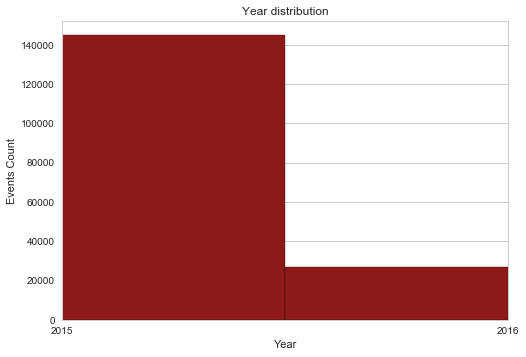

In [9]:
fig, ax = plt.subplots()
ax.hist(time_data['year'], bins=2, ec='k', color='#8D1919')
ax.set_title('Year distribution')
ax.set_xlabel('Year')
ax.set_ylabel('Events Count')
ax.set_xticks(range(2015, 2017, 1))
ax.set_xlim(range(2015, 2017, 1))

plt.show()

<p>And learn that the majority of the data was collected at 2015.</p>

<p>This led us to a question: is there available info about an entire year so we can see the distribution of the traffic inside the reserve in the period of twelve months?</p>

In [10]:
first_year_data = time_data[time_data.year == 2015]
first_year_data = first_year_data.groupby('month').count().sort_index().reindex(columns=['Timestamp'])
first_year_data

,Timestamp
month,
5,10561
6,25279
7,39518
8,31845
9,22907
10,8108
11,3816
12,2834


In [11]:
second_year_data = time_data[time_data.year == 2016]
second_year_data = second_year_data.groupby('month').count().sort_index().reindex(columns=['Timestamp'])
second_year_data

,Timestamp
month,
1,2971
2,4090
3,4455
4,4538
5,10555


<p>Unfortunaly no, but with a little trick we can see relevant data about the traffic distribution along an entire year. Since the only intersection between months is May, and even more, both events counts for the month are really close, we can substitute the month value in an entire year series for the media of this month.</p>

In [12]:
may_mean = int(round((first_year_data.loc[5]['Timestamp'] + second_year_data.loc[5]['Timestamp']) / 2))
may_mean

10558

In [13]:
whole_year = pd.concat([first_year_data.drop(5), second_year_data.drop(5)])
whole_year = whole_year.reindex(columns=['Timestamp'])
whole_year.loc[5] = may_mean
whole_year = whole_year.sort_index()

<p>And then we can finally plot the whole year sensor events distribution!</p>

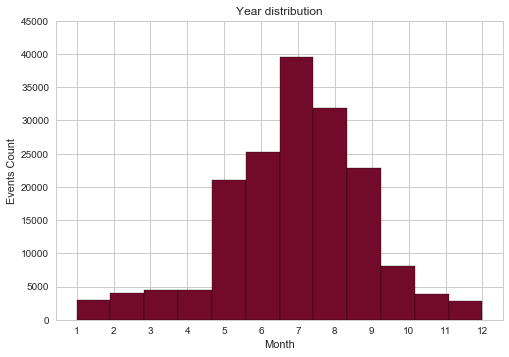

In [25]:
fig, ax = plt.subplots()
ax.hist(time_data['month'], bins = 12, ec='k', color='#720A2C')
ax.set_title('Year distribution')
ax.set_xlabel('Month')
ax.set_ylabel('Events Count')
ax.set_xticks(range(1, 13))
ax.set_yticks(range(0, 50000, 5000))

plt.show()

<p>This denotes a tendency of more visitor coming to the park by the half of the year, between July and September. This raises another relevant question: <b>could the increase in the visitors volume in this period influence the reproductive habits of the birds?</b></p>

<p>Then we proceed to visualize the distribution of sensor events along the hours of day. During which hours the traffic in the park peaks?</p>

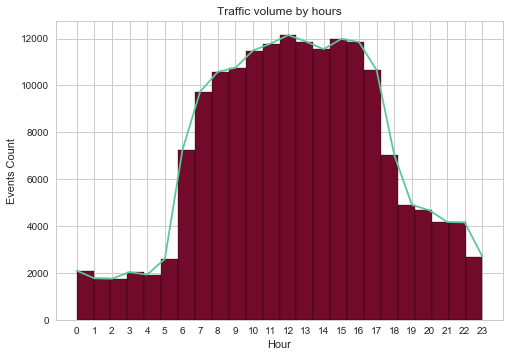

In [27]:
hours_data = time_data.groupby('hour').count().sort_index()

fig, ax = plt.subplots()
ax.hist(time_data['hour'], bins = 24, ec='k', color='#720A2C')
ax.plot(hours_data.index, hours_data['Timestamp'], color='#58C994')
ax.set_title('Traffic volume by hours')
ax.set_xlabel('Hour')
ax.set_ylabel('Events Count')
ax.set_xticks(range(0, 24))



plt.show()

<p>And we see that the distribution of events by hours of the day behaves normally, peaking in the interval from 6am to 18pm.</p>

<p>What can we learn about the time spent inside the park? Does the visitants come for a quick visit or they spend a long time inside the dependencies?</p>

In [28]:
time_delta = raw_dataset.groupby('car-id')['Timestamp'].max() - raw_dataset.groupby('car-id')['Timestamp'].min()
time_delta.head()

car-id
20150001010009-284   1 days 06:47:47
20150001050042-811   4 days 00:53:05
20150001060025-421   0 days 00:32:18
20150001070000-174   0 days 00:55:32
20150001070006-104   5 days 13:54:03
Name: Timestamp, dtype: timedelta64[ns]

<h3>5. <u>Exploratory Data Analysis</u></h3>

<p>Before jumping into conclusions, our team decided that having an overview of the dataset and their most relevant traits would be useful to direct our questioning process to the more evident trends in data.</p>

<p>Initially we're going to visualize the occurence of each car-type in every sensor. At this moment, we are not discriminating the different sensor types. Here we shall have a general perspective of how the car flow distribution by car type looks like. This approach shall give us our first general insight about the dataset.</p>

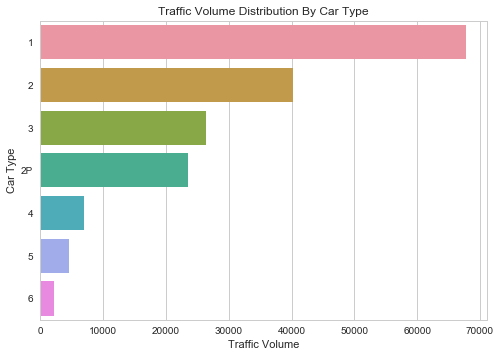

In [16]:
counts = raw_dataset.groupby("car-type").count().sort_values(by='Timestamp', ascending=False)

fig = sns.barplot(data=counts, x='car-id', y=counts.index)
fig.set(xlabel='Traffic Volume', ylabel='Car Type')
sns.plt.title('Traffic Volume Distribution By Car Type')


plt.show()

<p>To complement this visualization, we will visualize also how many cars have crossed each sensor, this time, not discrimining different car-types.</p>

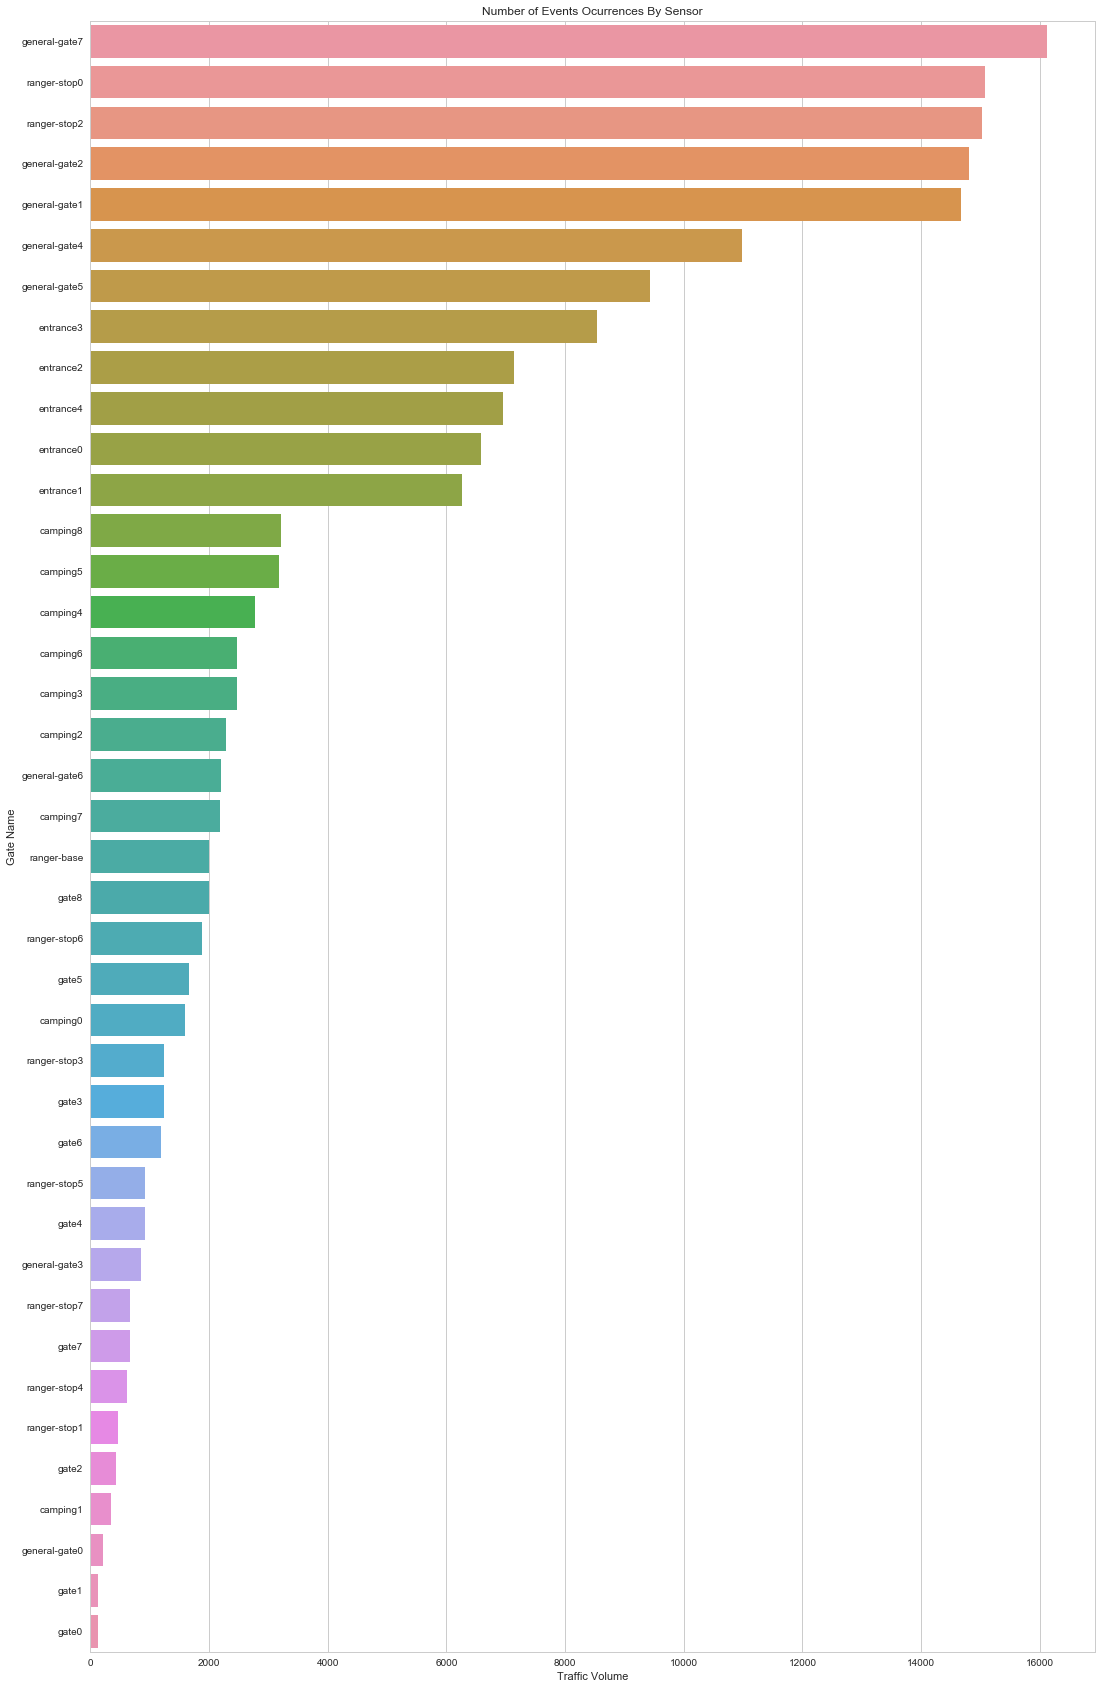

In [17]:
counts = raw_dataset.groupby("gate-name").count().sort_values(by='Timestamp', ascending=False)

fig = sns.barplot(data=counts, x='car-id', y=counts.index)
fig.set(xlabel='Traffic Volume', ylabel='Gate Name')
sns.plt.title('Number of Events Ocurrences By Sensor')
fig.figure.set_size_inches(18,30)

plt.show()

<p>At this point we have noticed that the sum of the vehicles counted by the ranger-stops 0 and 2 sensors extrapolates the total occurences of events involving ranger vehicles (2p). Therefore, it is confirmed that there are other visitors reaching these ranger areas. But this can be easily understood having a look on the park map. These two stops are not surronded by gates (which determines non visitors areas), so they are allowed to be reached by visitors. In the case of these areas being populated by the Rose-crested Blue Pipit the park should consider isolating these areas properly.</p>

<p>When confronted with this, what immediately came to our minds is that a easier way of visualizing the park roads configuration would be helpful for our analysis. So, manually we derived a graph representation of these roads as a csv file (presented at this project 'data' file) where the first column represents an origin point, the second column a destination point and the third is a boolean value indicating if this path is restricted by gates or not.</p>

<p>We then load the data from the csv file:</p>

In [18]:
roads = pd.read_csv('../data/roads.csv')

<p>And visualize the resulting graph using the <i>graphviz</i> module:</p>

In [19]:
graph = graphviz.Graph()
graph.attr(size='13,10')
graph.node_attr.update(color='lightblue2', style='filled', shape='circle')
locations = set()
for _, row in roads.iterrows():
    locations.add(row[0])
    locations.add(row[1])
for location in locations:
    graph.node(location)
for _, row in roads.iterrows():
    if row['restricted'] == 'True':
        graph.edge(row[0],row[1], color='red', penwidth='10')
    else:
        graph.edge(row[0],row[1])
graph
       

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

<p>Althogh being a little cluttered, this visualization enables us to spot quickly if a road is restricted (can only be acessed through gates) or not and might prove useful in our investigation process.</p>

<p>In fact, when we observe the graph visualization, it becomes clear that there are some sensors that can only be reached by passing through a gate, and therefore, should be only activated by rangers cars. We then direct our attention to the traffic activity at these areas. The sensors we'll investigate corresponds, in the visualization, to those that are only connected to the graph by red edges (restricted roads); They are:</p>


<ul>
    <li>Ranger-base</li>
    <li>ranger-stop 1</li>
    <li>ranger-stop 3</li>
    <li>ranger-stop 5</li>
    <li>ranger-stop 6</li>
    <li>ranger-stop 7</li>
</ul>